In [1]:
using Zygote
using JuMP
using Ipopt
using LinearAlgebra
using MathOptInterface
const MOI = MathOptInterface
using SparseArrays
using BenchmarkTools
using Plots

In [2]:
function restoration_phase(xk, ρ)
    println("Solving restoration problem")
    
    is_s_eq_0 = false
    
    nlrp = Model()
    set_silent(nlrp)
    @variable(nlrp, x[i=1:2])
    @NLobjective(nlrp, Min, (x[1] - 2)^2 + (x[2] - 2)^2)
    @NLconstraint(nlrp, c, x[1]^2 + x[2]^2 - 1 <= 0)
    pp = NLPEvaluator(nlrp)
    MOI.initialize(pp, [:Jac,:Grad,:Hess])

    while !is_s_eq_0
        
        #Constraint eval
        ggg=zeros(1)
        MOI.eval_constraint(pp,ggg,xk)

        #Jacobian eval
        JStru=MOI.jacobian_structure(pp)
        Ja=zeros(length(JStru))
        MOI.eval_constraint_jacobian(pp,Ja,xk)

        jr = Vector{Int64}(undef, length(Ja)); jc = Vector{Int64}(undef, length(Ja))
        for i in 1:length(JStru)
            jr[i] = JStru[i][1] |> Int
            jc[i] = JStru[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, Ja) 
        @assert size(Jacobeval, 1) == 1
                                        
        Jacobeval = vcat(Jacobeval...)
        
        restor_model = Model(Ipopt.Optimizer)
        set_silent(restor_model)
        @variable(restor_model, s >= 0)
        @variable(restor_model, d[i=1:2])

        @objective(restor_model, Min, s) 
        @constraint(restor_model, c1, ggg[1] + Jacobeval'*d - s <= 0)
        @constraint(restor_model, c2, d[1] <= ρ)
        @constraint(restor_model, c3, d[2] <= ρ) 
        @constraint(restor_model, c4, d[1] >= -ρ)
        @constraint(restor_model, c5, d[2] >= -ρ)
        optimize!(restor_model)

        proposed_xk = xk .+ value.(d)
        
        # merit function
        function m(x::Vector{<:Real}) 
            ce = zeros(1)
            MOI.eval_constraint(pp,ce,x)
            merit = norm(max(ce[1], 0))
            return merit
        end

        if abs(value(s)) < 1e-6
        elseif m(proposed_xk) < m(xk) 
            println("restoration merit condition: success")
            xk = proposed_xk
            ρ += 1*ρ
        else
            println("restoration merit condition: failed")
            ρ -= 0.5*ρ
        end
        
        println("slack = $(value(s))")
        is_s_eq_0 = abs(value(s)) < 1e-6
    end
    
    return xk, ρ 
end

restoration_phase (generic function with 1 method)

In [46]:
function SLP_MF(x0::Vector{<:Real}, ρ, γ)
    # ρ and γ are parameters
    @assert γ>=0
    
    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    xk = x0
    x_list = []
    
    nlmod = Model()
    set_silent(nlmod)
    @variable(nlmod, x[i=1:2])
    @NLobjective(nlmod, Min, (x[1] - 2)^2 + (x[2] - 2)^2)
    @NLconstraint(nlmod, c, x[1]^2 + x[2]^2 - 1 <= 0)
    p = NLPEvaluator(nlmod)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    

    while has_x_converged != [1, 1]
        ctr += 1
        
#         p = NLPEvaluator(nlmod)
#         MOI.initialize(p, [:Jac,:Grad,:Hess])
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)
        #@show df;

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)
        #@show g;

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)
        #@show J;

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1
                                        
        Jacobeval = vcat(Jacobeval...)

        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])
        @objective(model, Min, objEv + df'*d)
        @constraint(model, c1,  gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ) 
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)
        
        println("Iteration $ctr...")

        optimize!(model)
        @show termination_status(model)
#         @show value.(d)
        
        # updating ρ
        proposed_xk = xk .+ value.(d)
        
        # merit function
        function m(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            merit = newobjev + γ * norm(max(ce[1], 0))
            return merit
        end
        
        println("m(xk) = $(m(xk))")
        println("m(prop_xk) = $(m(proposed_xk))")
        
#         if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
        if m(proposed_xk) < m(xk)
            println("merit condition: success")
            xk = proposed_xk
            ρ += 1*ρ
            x_list = push!(x_list, xk)
        else
            println("merit condition: failed")
            ρ -= 0.5*ρ
            x_list = push!(x_list, xk)
        end
        
        
        
        println("d=$(value.(d))")
        println("x$(ctr)=$(xk)")
        println("new ρ: $ρ")
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
        
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
        
    end
    println("no. restoration phases: $(restor_ctr)")
    return x_list
end

SLP_MF (generic function with 1 method)

In [47]:
x_list_1 = SLP_MF([-10., 20.], 4, 1)

Iteration 1...
termination_status(model) = MathOptInterface.LOCALLY_INFEASIBLE
m(xk) = 967.0
m(prop_xk) = 246.3512538159508
merit condition: success
d=[4.000000039999394, -10.474999855251209]
x1=[-5.999999960000606, 9.525000144748791]
new ρ: 8
Solving restoration problem
slack = -7.494168126276467e-9
Iteration 2...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 246.3512538159508
m(prop_xk) = 5.551250615693256
merit condition: success
d=[8.000000079843378, -8.000000079833491]
x2=[2.000000119842772, 1.5250000649153002]
new ρ: 16
Iteration 3...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 5.551250615693256
m(prop_xk) = 998.8974966422077
merit condition: failed
d=[-15.995770054036878, 16.00000015904306]
x3=[2.000000119842772, 1.5250000649153002]
new ρ: 8.0
Iteration 4...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 5.551250615693256
m(prop_xk) = 246.35125371276675
merit condition: failed
d=[-8.000000079167872, 8.00000007736

Iteration 32...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 3.3427596122950054
m(prop_xk) = 3.3431459167199424
merit condition: failed
d=[-0.00024333964650630535, -8.661326976180382e-5]
x32=[0.7075511577241789, 0.7069923536850367]
new ρ: 0.0001220703125
Iteration 33...
termination_status(model) = MathOptInterface.LOCALLY_INFEASIBLE
m(xk) = 3.3427596122950054
m(prop_xk) = 3.3431460104564312
merit condition: failed
d=[-0.00020789647936967503, -0.00012208347952866904]
x33=[0.7075511577241789, 0.7069923536850367]
new ρ: 6.103515625e-5
Solving restoration problem
restoration merit condition: success
slack = 0.00029412441839947294
slack = -7.481250313875847e-9
Iteration 34...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 3.342902580188081
m(prop_xk) = 3.3431461134484266
merit condition: failed
d=[-0.00012130708288491719, -8.663048939981457e-5]
x34=[0.7074901143365331, 0.7069313102987865]
new ρ: 6.103515625e-5
Iteration 35...
termination_status(mo

45-element Vector{Any}:
 [-5.999999960000606, 9.525000144748791]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [1.000000111858043, 1.0903688176660344]
 [1.000000111858043, 1.0903688176660344]
 [1.000000111858043, 1.0903688176660344]
 [1.000000111858043, 1.0903688176660344]
 [1.000000111858043, 1.0903688176660344]
 [0.8750001031115977, 0.9653688088154478]
 [0.8750001031115977, 0.9653688088154478]
 ⋮
 [0.7074901143365331, 0.7069313102987865]
 [0.7074901143365331, 0.7069313102987865]
 [0.7073985450883031, 0.7068397410533301]
 [0.7073985450883031, 0.7068397410533301]
 [0.7073985450883031, 0.7068397410533301]
 [0.7073985450883031, 0.7068397410533301]
 [0.7073985450883031, 0.7068397410533301]
 [0.7073870845896918, 0.7068282805575449]
 [0.7073870845896918, 0.7068282805575449]
 [0.7073870845896918, 0.7068282805575449]
 [0.70738708458969

In [48]:
x1 = []
x2 = []

for x in 1:length(x_list_1)
    x1 = push!(x1, x_list_1[x][1])
    x2 = push!(x2, x_list_1[x][2])
end
# display(x1)
# display(x2)

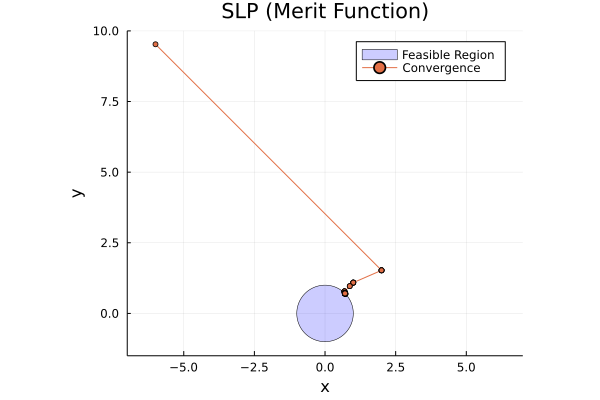

In [49]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

slpmfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
plot!(slpmfplot, x1,x2, markershape = :circle, markersize = 3, xlims=(-7, 7), ylims=(-1.5,10), label="Convergence", xlabel = "x", ylabel = "y", title="SLP (Merit Function)")

In [7]:
savefig(slpmfplot, "slpmfplot.pdf")

In [51]:
function SLP_F(x0::Vector{<:Real}, ρ)
    # ρ is the trust region parameter

    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    xk = x0
    
    x_list =[]
    filt = []
    
    nlmod = Model()
    set_silent(nlmod)
    @variable(nlmod, x[i=1:2])
    @NLobjective(nlmod, Min, (x[1] - 2)^2 + (x[2] - 2)^2)
    @NLconstraint(nlmod, c, x[1]^2 + x[2]^2 - 1 <= 0)
    p = NLPEvaluator(nlmod)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    
    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1                              
        Jacobeval = vcat(Jacobeval...)
        
        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])

        println("Iteration $ctr...")

        @objective(model, Min, objEv + df'*d) 
        @constraint(model, c1, gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ)
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)

        optimize!(model)
        
        #functions for making the filter
        function fk(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            return newobjev
        end
        function hk(x::Vector{<:Real}) 
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            h = norm(max(ce[1], 0))
            return h
        end
        
        proposed_xk = xk .+ value.(d)
        better_obj = all(v -> fk(proposed_xk) < v[1], filt)
        better_constr = all(v -> hk(proposed_xk) < v[2], filt)
        
#         if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
        if better_obj || better_constr
            println("filter: accept")
            xk = proposed_xk
            ρ += 1*ρ
            filt = push!(filt, (fk(xk), hk(xk)))
            x_list = push!(x_list, xk)
        else
            println("filter: reject")
            ρ -= 0.5*ρ
            filt = push!(filt, (fk(proposed_xk), hk(proposed_xk)))
            x_list = push!(x_list, xk)
        end
        
        
        
        println("f(propxk) = $(fk(proposed_xk))")
        println("d=$(value.(d))")
        println("x$(ctr)=$xk")  
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
    
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
    end
    println("no. restoration phases: $(restor_ctr)")
    return x_list
end


SLP_F (generic function with 1 method)

In [52]:
x_list_2 = SLP_F([-10., 20.], 4)

Iteration 1...
filter: accept
f(propxk) = 120.62562653847903
d=[4.000000039999394, -10.474999855251209]
x1=[-5.999999960000606, 9.525000144748791]
Solving restoration problem
slack = -7.494168126276467e-9
Iteration 2...
filter: accept
f(propxk) = 0.22562493833048342
d=[8.000000079843378, -8.000000079833491]
x2=[2.000000119842772, 1.5250000649153002]
Iteration 3...
filter: reject
f(propxk) = 496.8902877415753
d=[-15.995770054036878, 16.00000015904306]
x3=[2.000000119842772, 1.5250000649153002]
Iteration 4...
filter: reject
f(propxk) = 120.62562649047851
d=[-8.000000079167872, 8.000000077362234]
x4=[2.000000119842772, 1.5250000649153002]
Iteration 5...
filter: reject
f(propxk) = 25.1493850738291
d=[-4.000000037993978, 3.4997950899041874]
x5=[2.000000119842772, 1.5250000649153002]
Iteration 6...
filter: accept
f(propxk) = 4.161478404606334
d=[-2.0000000179897572, 0.8768441984733707]
x6=[1.0185301491105747e-7, 2.401844263388671]
Iteration 7...
filter: reject
f(propxk) = 16.946725535212064


Iteration 57...
filter: reject
f(propxk) = 3.3431455365734113
d=[0.00024184840407495974, -0.0002417969152103331]
x57=[0.7069176410685825, 0.7072959546956642]
Iteration 58...
filter: accept
f(propxk) = 3.3431457095096047
d=[0.00011976175420224282, -0.00011977556622454556]
x58=[0.7070374028227847, 0.7071761791294396]
Iteration 59...
filter: reject
f(propxk) = 3.343145688394497
d=[0.00023789309973933645, -0.00023786669979640102]
x59=[0.7070374028227847, 0.7071761791294396]
Iteration 60...
filter: accept
f(propxk) = 3.3431456978405762
d=[0.00011591567567613722, -0.00011591321260014478]
x60=[0.7071533184984609, 0.7070602659168395]
Iteration 61...
filter: reject
f(propxk) = 3.3431457336751267
d=[-0.00023487538812087819, 0.0002348872960295528]
x61=[0.7071533184984609, 0.7070602659168395]
Iteration 62...
filter: accept
f(propxk) = 3.3431457130284885
d=[-0.00011303785446131436, 0.00011303372795016702]
x62=[0.7070402806439996, 0.7071732996447896]
Iteration 63...
filter: reject
f(propxk) = 3.3431

73-element Vector{Any}:
 [-5.999999960000606, 9.525000144748791]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [2.000000119842772, 1.5250000649153002]
 [1.0185301491105747e-7, 2.401844263388671]
 [1.0185301491105747e-7, 2.401844263388671]
 [2.0000001212264857, 0.401844246513432]
 [2.0000001212264857, 0.401844246513432]
 [2.0000001212264857, 0.401844246513432]
 [1.003696553382585, 1.4018442557430884]
 [1.003696553382585, 1.4018442557430884]
 [1.417723313198092, 0.4018442473210697]
 ⋮
 [0.7070402806439996, 0.7071732996447896]
 [0.7070402806439996, 0.7071732996447896]
 [0.7070402806439996, 0.7071732996447896]
 [0.707095570555551, 0.7071180020653866]
 [0.707095570555551, 0.7071180020653866]
 [0.707131695440435, 0.7070818740027517]
 [0.707131695440435, 0.7070818740027517]
 [0.707131695440435, 0.7070818740027517]
 [0.707112582583178, 0.7071009863609097]
 [0.7071075520606045, 0.7071060164495423]
 [0.7071075520606045

In [53]:
x11 = []
x22 = []

for x in 1:length(x_list_2)
    x11 = push!(x11, x_list_2[x][1])
    x22 = push!(x22, x_list_2[x][2])
end

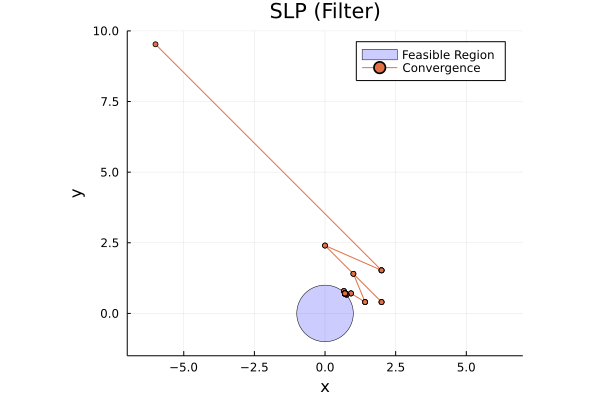

In [54]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

slpfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
plot!(slpfplot, x11,x22, markershape = :circle, markersize = 3, xlims=(-7, 7), ylims=(-1.5,10), label="Convergence", xlabel = "x", ylabel = "y", title="SLP (Filter)", legend=:topright)

In [9]:
savefig(slpfplot, "slpfplot.pdf")

In [23]:
function SQP_MF(x0::Vector{<:Real}, λ0::Vector{Float64}, ρ, γ)
    # λ, μ are initial lagrangian multipliers
    # ρ and γ are parameters

    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    xk = x0
    λk = λ0
    x_list = []
    
    # hessian of the lagrangian model
    mhl = Model(Ipopt.Optimizer)
    @variable(mhl, x[i=1:2])
    @NLobjective(mhl, Min, (x[1] - 2)^2 + (x[2] - 2)^2 )
    @NLconstraint(mhl, c, x[1]^2 + x[2]^2 - 1 <= 0)
    p = NLPEvaluator(mhl)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    
    
    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1                              
        Jacobeval = vcat(Jacobeval...)
        
        #Hessian-of-the-Lagrangian eval
        HStr=MOI.hessian_lagrangian_structure(p)
        H=zeros(length(HStr))
        MOI.eval_hessian_lagrangian(p,H,xk,1.0,repeat(λk,length(H))) # instead of repeat have lagrange multipliers
        
        hr = Vector{Int64}(undef, length(H)); hc = Vector{Int64}(undef, length(H))
        for i in 1:length(HStr)
            hr[i] = HStr[i][1] |> Int
            hc[i] = HStr[i][2] |> Int
        end
        
        HessLag = sparse(hr, hc, H)
        
        hessianobj(d) = 0.5*d'*(HessLag*d)
        
        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])
        
        println("Iteration $ctr...")

        @objective(model, Min, objEv + df'*d + hessianobj(d)) 
        @constraint(model, c1, gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ)
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)

        optimize!(model)
        @show termination_status(model)
        
        # update λ
        λk[1] = shadow_price(c1)

        # merit function
        function m(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            merit = newobjev + γ * norm(max(ce[1], 0))
            return merit
        end
        
        # updating ρ
        proposed_xk = xk .+ value.(d)
        println("m(xk) = $(m(xk))")
        println("m(prop_xk) = $(m(proposed_xk))")
        
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
        elseif m(proposed_xk) < m(xk)
            println("merit condition: success")
            xk = proposed_xk
            ρ += 1*ρ
        else
            println("merit condition: failed")
            ρ -= 0.5*ρ
        end
        
        println("d=$(value.(d))")
        println("x$ctr=$xk")
        
        x_list = push!(x_list, xk)
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
        
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
    end
    println("no. restoration phases: $(restor_ctr)")
    return x_list
end

SQP_MF (generic function with 1 method)

In [24]:
x_list_3 = SQP_MF([-10., 20.], [0.], 4, 1)

Iteration 1...
termination_status(model) = MathOptInterface.LOCALLY_INFEASIBLE
m(xk) = 967.0
m(prop_xk) = 246.35125381595066
d=[4.000000039999394, -10.474999855251212]
x1=[-10.0, 20.0]
Solving restoration problem
restoration merit condition: success
slack = 258.99999261751776
slack = -7.4942552148903e-9
Iteration 2...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 550.9999964872673
m(prop_xk) = 102.9999971213983
merit condition: success
d=[8.000000079993734, -8.000000079993917]
x2=[2.0000001198684387, 7.9999998800687315]
Iteration 3...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 102.9999971213983
m(prop_xk) = 6.9999999958319155
merit condition: success
d=[-1.2004124493745127e-7, -5.9999998809379465]
x3=[1.9999999998271938, 1.999999999130785]
Iteration 4...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 6.9999999958319155
m(prop_xk) = 3.062500007805765
merit condition: success
d=[-0.8749999921737683, -0.8749999911726808]


restoration merit condition: success
slack = 0.002548086896105854
slack = -7.49408801259039e-9
Iteration 32...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 3.341037850843809
m(prop_xk) = 3.343148832580587
merit condition: failed
d=[0.00015231070952525884, -0.0019531342027149794]
x32=[0.7080077692815848, 0.7080077695862638]
Iteration 33...
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
m(xk) = 3.341037850843809
m(prop_xk) = 3.3431444007992255
merit condition: failed
d=[-0.0009004120892873466, -0.0009004123561572268]
x33=[0.7080077692815848, 0.7080077695862638]
Iteration 34...
termination_status(model) = MathOptInterface.LOCALLY_INFEASIBLE
m(xk) = 3.341037850843809
m(prop_xk) = 3.343144399656651
d=[-0.0008870721230299882, -0.0009137507396615206]
x34=[0.7080077692815848, 0.7080077695862638]
Solving restoration problem
restoration merit condition: success
slack = 0.0011671446803522406
slack = -7.494076014117328e-9
Iteration 35...
termination_status(model

48-element Vector{Any}:
 [-10.0, 20.0]
 [2.0000001198684387, 7.9999998800687315]
 [1.9999999998271938, 1.999999999130785]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 [1.1250000076534254, 1.1250000079581044]
 ⋮
 [0.7075194798012718, 0.7075194801059508]
 [0.7072753309471257, 0.7072753312518046]
 [0.7072753309471257, 0.7072753312518046]
 [0.7072753309471257, 0.7072753312518046]
 [0.7071532524038157, 0.7071532527084946]
 [0.7071532524038157, 0.7071532527084946]
 [0.7071532524038157, 0.7071532527084946]
 [0.7071532524038157, 0.7071532527084946]
 [0.7071227264582228, 0.7071227267629018]
 [0.7071227264582228, 0.7071227267629018]
 [0.7071227264582228, 0.70712272676

In [25]:
x111 = []
x222 = []

for x in 1:length(x_list_3)
    x111 = push!(x111, x_list_3[x][1])
    x222 = push!(x222, x_list_3[x][2])
end

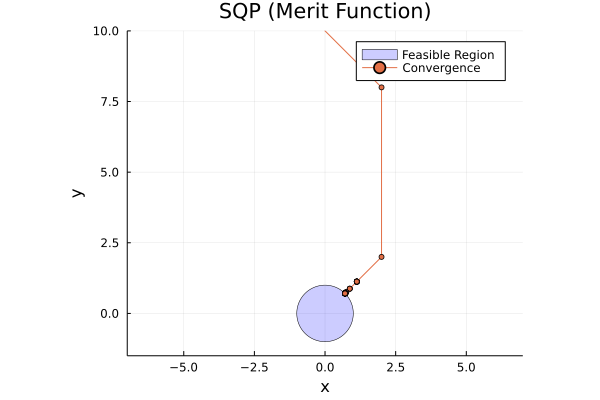

In [26]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

sqpmfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
plot!(sqpmfplot, x111,x222, markershape = :circle, markersize = 3, xlims=(-7,7), ylims=(-1.5,10), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Merit Function)", legend=:topright)

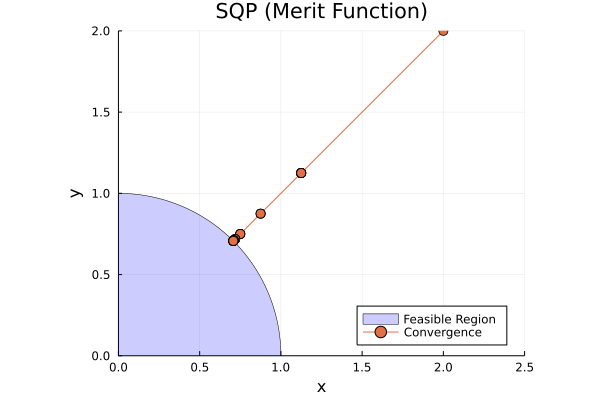

In [27]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

sqpmfplotclose = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
plot!(sqpmfplotclose, x111,x222, markershape = :circle, markersize = 5, xlims=(0,2.5), ylims=(0,2), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Merit Function)",legend=:bottomright)

In [38]:
savefig(sqpmfplotclose, "sqpmfplotclose.pdf")

In [39]:
savefig(sqpmfplot, "sqpmfplot.pdf")

In [30]:
function SQP_F(x0::Vector{<:Real}, λ0::Vector{Float64}, ρ)
    # λ is initial lagrangian multiplier
    # ρ is the trust region parameter

    xk = x0
    λk = λ0
    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    x_list = []
    filt = []
    
    # hessian of the lagrangian model
    mhl = Model(Ipopt.Optimizer)
    @variable(mhl, x[i=1:2])
    @NLobjective(mhl, Min, (x[1] - 2)^2 + (x[2] - 2)^2 )
    @NLconstraint(mhl, c1, x[1]^2 + x[2]^2 - 1 <= 0)
    p = NLPEvaluator(mhl)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    
    
    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1                              
        Jacobeval = vcat(Jacobeval...)
        
        #Hessian-of-the-Lagrangian eval
        HStr=MOI.hessian_lagrangian_structure(p)
        H=zeros(length(HStr))
        MOI.eval_hessian_lagrangian(p,H,xk,1.0,repeat(λk,length(H))) 
        
        hr = Vector{Int64}(undef, length(H)); hc = Vector{Int64}(undef, length(H))
        for i in 1:length(HStr)
            hr[i] = HStr[i][1] |> Int
            hc[i] = HStr[i][2] |> Int
        end
        HessLag = sparse(hr, hc, H)
        
        hessianobj(d) = 0.5*d'*(HessLag*d)
        
        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])
        
        println("Iteration $ctr...")

        @objective(model, Min, objEv + df'*d + hessianobj(d)) 
        @constraint(model, c1, gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ)
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)

        optimize!(model)
        
        # update λ
        λk[1] = shadow_price(c1)

        #functions for making the filter
        function fk(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            return newobjev
        end
        function hk(x::Vector{<:Real}) 
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            h = norm(max(ce[1], 0))
            return h
        end
        
        # updating ρ
        proposed_xk = xk .+ value.(d)
        better_obj = all(v -> fk(proposed_xk) < v[1], filt)
        better_constr = all(v -> hk(proposed_xk) < v[2], filt)
        
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
        elseif better_obj || better_constr
            println("filter: accept")
            xk = proposed_xk
            ρ += 1*ρ
            filter = push!(filt, (fk(xk), hk(xk)))
            x_list = push!(x_list, xk)
        else
            println("filter: reject")
            ρ -= 0.5*ρ
            filter = push!(filt, (fk(proposed_xk), hk(proposed_xk)))
            x_list = push!(x_list, xk)
        end
        
        println("f(propxk) = $(fk(proposed_xk))")
        println("d=$(value.(d))")
        println("x$ctr=$xk")
        
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
        
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
    end
    println("no. restoration phases: $(restor_ctr)")
    return x_list
end

SQP_F (generic function with 1 method)

In [31]:
x_list_4 = SQP_F([-10., 20.], [0.], 4)

Iteration 1...
f(propxk) = 120.62562653847897
d=[4.000000039999394, -10.474999855251212]
x1=[-10.0, 20.0]
Solving restoration problem
restoration merit condition: success
slack = 258.99999261751776
slack = -7.4942552148903e-9
Iteration 2...
filter: accept
f(propxk) = 35.99999856082481
d=[8.000000079993734, -8.000000079993917]
x2=[2.0000001198684387, 7.9999998800687315]
Iteration 3...
filter: accept
f(propxk) = 7.853965686033671e-19
d=[-1.2004124493745127e-7, -5.9999998809379465]
x3=[1.9999999998271938, 1.999999999130785]
Iteration 4...
filter: accept
f(propxk) = 1.531249972679823
d=[-0.8749999921737683, -0.8749999911726808]
x4=[1.1250000076534254, 1.1250000079581044]
Iteration 5...
filter: accept
f(propxk) = 2.953800129158819
d=[-0.3402777798797792, -0.34027778093487115]
x5=[0.7847222277736463, 0.7847222270232332]
Iteration 6...
filter: accept
f(propxk) = 3.3233246318081218
d=[-0.07377706072807891, -0.07377702393643712]
x6=[0.7109451670455674, 0.7109452030867961]
Iteration 7...
filter:

16-element Vector{Any}:
 [2.0000001198684387, 7.9999998800687315]
 [1.9999999998271938, 1.999999999130785]
 [1.1250000076534254, 1.1250000079581044]
 [0.7847222277736463, 0.7847222270232332]
 [0.7109451670455674, 0.7109452030867961]
 [0.7109451670455674, 0.7109452030867961]
 [0.7109451670455674, 0.7109452030867961]
 [0.7109451670455674, 0.7109452030867961]
 [0.7109451670455674, 0.7109452030867961]
 [0.7071171787900574, 0.7071171132476112]
 [0.7071171787900574, 0.7071171132476112]
 [0.7071171787900574, 0.7071171132476112]
 [0.7071171787900574, 0.7071171132476112]
 [0.7071067243944297, 0.7071068442322591]
 [0.7071067243944297, 0.7071068442322591]
 [0.7071068940346882, 0.7071066744401947]

In [32]:
x1111 = []
x2222 = []

for x in 1:length(x_list_4)
    x1111 = push!(x1111, x_list_4[x][1])
    x2222 = push!(x2222, x_list_4[x][2])
end

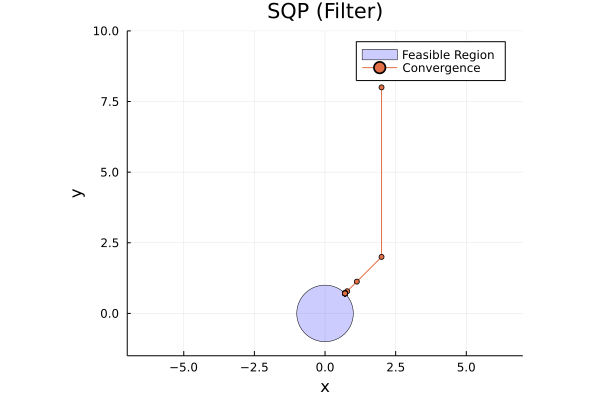

In [33]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

sqpfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
plot!(sqpfplot, x1111,x2222, markershape = :circle, markersize = 3, xlims=(-7,7), ylims=(-1.5,10), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Filter)", legend=:topright)

In [40]:
savefig(sqpfplot, "sqpfplot.pdf")

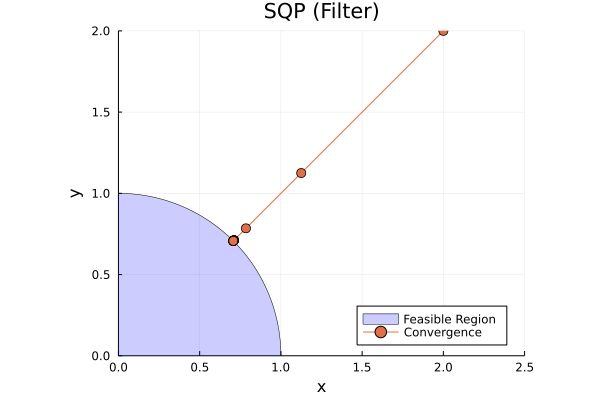

In [41]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

sqpfplotclose = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
plot!(sqpfplotclose, x1111,x2222, markershape = :circle, markersize = 5, xlims=(0,2.5), ylims=(0,2), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Filter)", legend=:bottomright)

In [42]:
savefig(sqpfplotclose, "sqpfplotclose.pdf")